In [1]:
#Question: How does changing the SRC Eigenmode ONLY effect the QM-limited Sensitivity?
#Question: How does changing the lensing of the beam coming from SRC effect the QM-limited Sensitivity?
####

In [2]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
from pykat.tools import modematching
import pylab as pl
import pandas
import matplotlib.pyplot as plt
import matplotlib
import csv
import math
import numpy as np

### My functions
from kat_commands import *
from MMT import modematch
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

                                              ..-
    PyKat 1.0.9           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat



In [3]:
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

In [4]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat = pykat.finesse.kat() 
basekat.loadKatFile(katfile)
basekat.parseCommands(darm_commands)
basekat.parseCommands(amplitude_detectors)
basekat.parseCommands(pds)
basekat.parseCommands(add_squeezing)
basekat.parseCommands("maxtem "+str(2))
basekat.undumpNodes() #undump the vacuum nodes
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out_perfect_mm = kat.run()

SR3_Rc_orig = kat.SR3.Rc.value
SRMHR_Rc_orig = kat.SRMHR.Rc.value

#out_perfect_mm_trace = kat.run(getTraceData=True)

In [5]:
#load the original kat file (ie Perfect Modematching) as a reference
basekat0 = pykat.finesse.kat() 
basekat0.loadKatFile(katfile)
basekat0.parseCommands(darm_commands)
basekat0.parseCommands(amplitude_detectors)
basekat0.parseCommands(pds)
basekat0.parseCommands(add_squeezing)
basekat0.parseCommands("maxtem "+str(2))
basekat0.undumpNodes() #undump the vacuum nodes
kat0=basekat0.deepcopy() #copy kat code
kat0.verbose = False

kat0.lFC1.L.value = 16.0005

out_perfect_mm_shiftFCL = kat0.run()

In [6]:
SRCTL_q_perfect_x = out_perfect_mm["SRCoutx"] #q's coming out of the SRC @ the OFI
SRCTL_q_perfect_y = out_perfect_mm["SRCouty"]

SRMY_q_perfect_x = out_perfect_mm["SRMYqx"] #q's at the face of SRMHR
SRMY_q_perfect_y = out_perfect_mm["SRMYqy"]

In [7]:
kat.IMFC.T.value

6.1e-05

In [18]:
###
###Extract the eigenmode of SRC with offsets in SR3
###

max_offset_SR3 = .01634 #20cm Roc change in SR3 curvature
steps = 5
IMFC_T = kat.IMFC.T.value
dL_IMFC_T = -5e-5
dL_IMFC_T_list = []

get_OFI_qx_wrt_OMC_list=[]
get_OFI_qy_wrt_OMC_list=[]

get_SRM_qx_wrt_cavARM_list = []
get_SRM_qy_wrt_cavARM_list = []

for i in range(0,steps,1):
    dT = (float(i)/steps) * dL_IMFC_T
    dL_IMFC_T_list.append(dT)
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.undumpNodes()
    basekat1.parseCommands("maxtem "+str(2))
    kat1=basekat1.deepcopy() 
    kat1.verbose = False
    
    # Change the SRMHR_Roc
    SR3_Rc_new = SR3_Rc_orig + max_offset_SR3
    kat1.SR3.Rcx.value = SR3_Rc_new
    kat1.SR3.Rcy.value = SR3_Rc_new

    #Change the IMFC T
    kat1.IMFC.T.value = kat.IMFC.T.value + dT
    kat1.IMFC.L.value = 0
    kat1.IMFC.R.value = 1 - kat1.IMFC.T.value
    
    #Run and extract the q's at the OFI and SRMHR
    out_new_SRM_roc = kat1.run()
   
    #### Extract the mode at the SRMAR w.r.t the ARM
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavXARM.enabled = True
    kat1.cavYARM.enabled = True
    
    get_SRM_q_wrt_cavARM = kat1.run(getTraceData=True)
    get_SRM_qx_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][0]._gauss_param__q)
    get_SRM_qy_wrt_cavARM_list.append(get_SRM_q_wrt_cavARM[1][0]['nSRMARb'][1]._gauss_param__q)
    
    
    #### Extract the mode at the OFI w.r.t the OMC
    for cav in kat1.getAll(pykat.commands.cavity):
        cav.enabled = False
    kat1.cavOMC.enabled = True
    get_OFI_qx_wrt_OMC = kat1.run(getTraceData=True)
    get_OFI_qx_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][0]._gauss_param__q))
    get_OFI_qy_wrt_OMC_list.append(-np.conjugate(get_OFI_qx_wrt_OMC[1][0]['nIBAin'][1]._gauss_param__q))


q_refin_x_list = get_SRM_qx_wrt_cavARM_list
q_refin_y_list = get_SRM_qy_wrt_cavARM_list

q_refout_x_list = get_OFI_qx_wrt_OMC_list
q_refout_y_list = get_OFI_qy_wrt_OMC_list

In [19]:
darm_list = []
freq = []
f_overlap_SRC_to_ARM_x=[]
f_overlap_SRC_to_ARM_y=[]

f_overlap_OMC_to_ARM_x = []
f_overlap_OMC_to_ARM_y = []

f_overlap_FC_to_ARM_x = []
f_overlap_FC_to_ARM_y = []

for i in range(0,steps,1):
    dT = (float(i)/steps) * dL_IMFC_T
    dL_IMFC_T_list.append(dT)
    #Add Commands
    basekat1 = pykat.finesse.kat() 
    basekat1.loadKatFile(katfile)
    basekat1.parseCommands(darm_commands)
    basekat1.parseCommands(amplitude_detectors)
    basekat1.parseCommands(pds)
    basekat1.parseCommands(add_squeezing)
    basekat1.parseCommands("maxtem "+str(2))
    basekat1.undumpNodes()
    kat1=basekat1.deepcopy()
    kat1.verbose = False

    SR3_Rc = kat.SR3.Rc
    dRc = max_offset_SR3

    kat1.SR3.Rcx.value = SR3_Rc + dRc
    kat1.SR3.Rcy.value = SR3_Rc + dRc

    #Change the IMFC T
    kat1.IMFC.T.value = kat.IMFC.T.value + dT
    kat1.IMFC.L.value = 0
    kat1.IMFC.R.value = 1 - kat1.IMFC.T.value
    
    #
    #    q1   d1   f1  d2   f2  d3   q2
    #    |   <-->  |  <-->  | <-->  |
    #    | <---------- D ---------> |
    #

    q1 = q_refin_x_list[0]
    q2 = q_refout_x_list[0]
    D  = 0.491516 # total distance from SRC to OFI
    d1 = 0.25
    d2 = 0.0001
    d3 = D-d1-d2

    [f1, f2] = modematch(q1, q2, d1, d2, d3)

    kat1.lSRMTT1.L.value = d1
    kat1.SRMTT1.f.value = f1
    kat1.lSRMTT2.L.value = d2
    kat1.SRMTT2.f.value = f2
    kat1.lIBAin.L.value = d3

    out1 = kat1.run()

    freq.append(out1.x)
    darm_list.append(out1['NSR_with_RP'])
    kat1.saveScript("VarySR3_95MM_wSqz_MMTTon_maxtem4.kat")


    #### Turn off all the cav commands except FC to extract the eigenmode at the BS
    [FCx,FCy] = trace_mode.from_cav_to_BS(kat1,'cavFC')
    
    #### Turn off all the cav commands except SRCY to extract the eigenmode at the BS
    [srcx,srcy] = trace_mode.from_cav_to_BS(kat1,'cavSRY')

    #### Turn off all the cav commands except YARM to extract the eigenmode at the BS
    [ARMx,ARMy] = trace_mode.from_cav_to_BS(kat1,'cavXARM')

    #### Turn off all the cav commands except OMC to extract the eigenmode at the BS
    [OMCx,OMCy] = trace_mode.from_cav_to_BS(kat1,'cavOMC')

    f_overlap_SRC_to_ARM_x.append(pykat.beam_param.overlap(srcx,ARMx))
    f_overlap_SRC_to_ARM_y.append(pykat.beam_param.overlap(srcy,ARMy))


    f_overlap_FC_to_ARM_x.append(pykat.beam_param.overlap(FCx,ARMx))
    f_overlap_FC_to_ARM_y.append(pykat.beam_param.overlap(FCy,ARMy))

Successfully Mode-Matched! >99.9% overlap
f1 is 0.001495753375465786
f2 is -0.001395706688821341
Successfully Mode-Matched! >99.9% overlap
f1 is 0.001495753375465786
f2 is -0.001395706688821341
Successfully Mode-Matched! >99.9% overlap
f1 is 0.001495753375465786
f2 is -0.001395706688821341
Successfully Mode-Matched! >99.9% overlap
f1 is 0.001495753375465786
f2 is -0.001395706688821341
Successfully Mode-Matched! >99.9% overlap
f1 is 0.001495753375465786
f2 is -0.001395706688821341


In [20]:
f_overlap_FC_to_ARM_x

[0.9999932371279066,
 0.9999932371279066,
 0.9999932371279066,
 0.9999932371279066,
 0.9999932371279066]

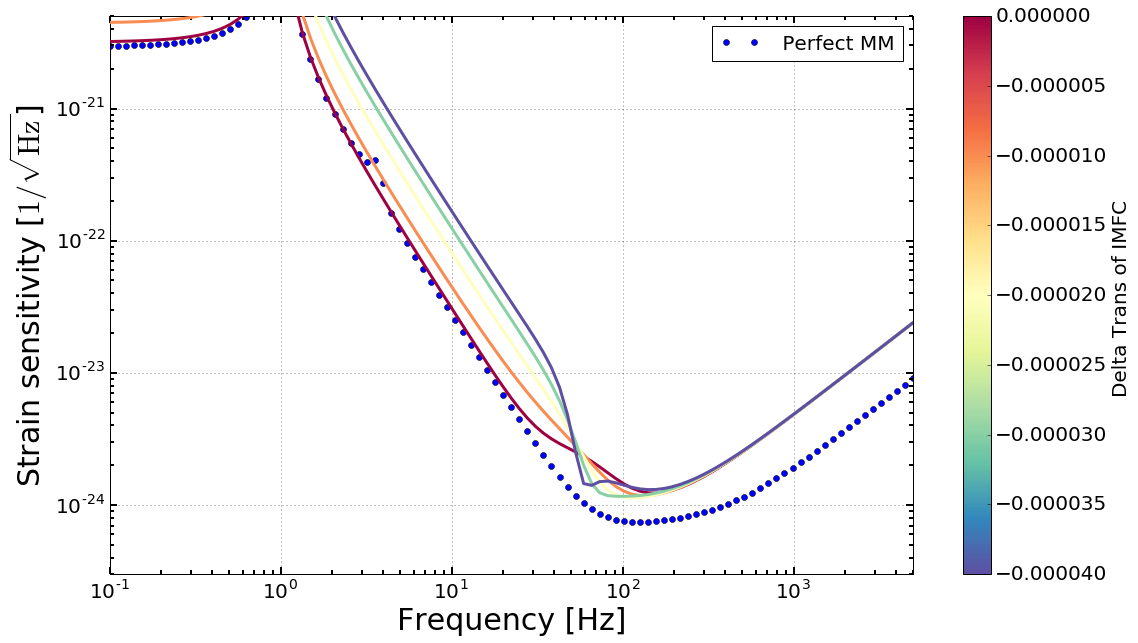

In [21]:
pl.figure(figsize=(18, 10), dpi=80)

cm = pl.cm.Spectral_r
norm = matplotlib.colors.Normalize(min(dL_IMFC_T_list),max(dL_IMFC_T_list))

s_m = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
s_m.set_array([])


for i in range(len(darm_list)):
    c = c = s_m.to_rgba(dL_IMFC_T_list[i])
    pl.subplot(111)
    pl.loglog(freq[0], np.real(darm_list[i]),linewidth=3,zorder=1000, color = c,)

pl.loglog(out_perfect_mm.x, np.real(out_perfect_mm['NSR_with_RP']),'o',label=' Perfect MM')

#pl.title("ARMtoOMC::QN-Limited Varying SR3 w/10Db Sqz",fontsize=30)
pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,5e-21)
pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

###Colorbar formatting
cb = pl.colorbar(s_m)
cb.set_label("Delta Trans of IMFC ", fontsize = 20)
cb.ax.tick_params(labelsize=20) 
cb.update_ticks()



pl.show()

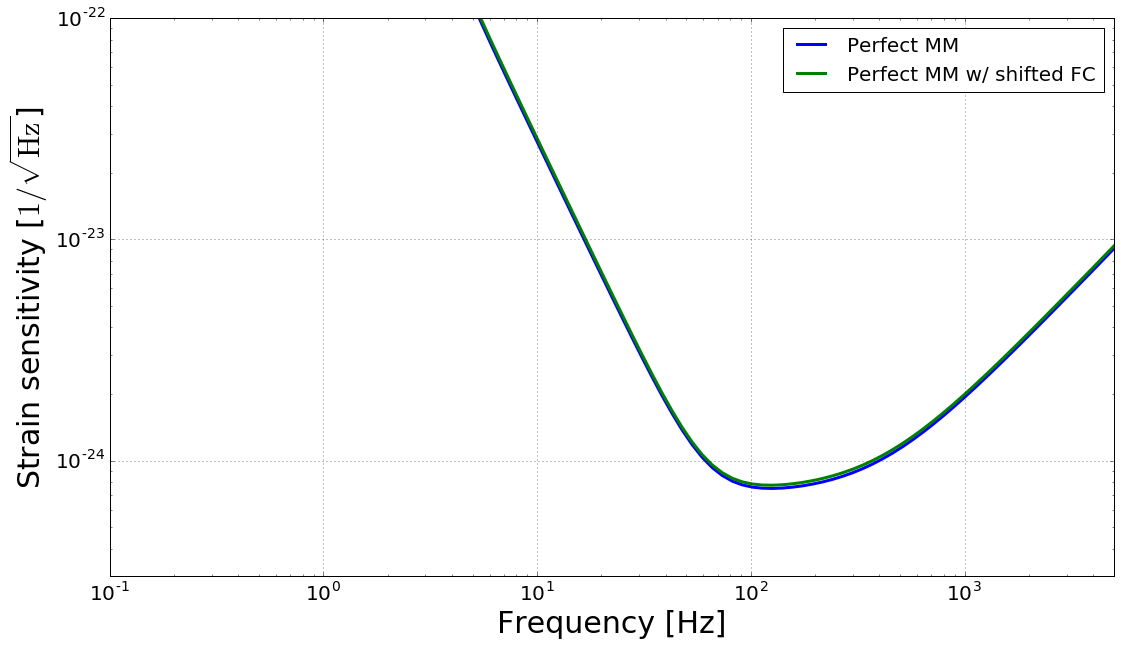

In [22]:
pl.figure(figsize=(18, 10), dpi=80)


pl.subplot(111)

pl.loglog(freq[0], np.real(out_perfect_mm['NSR_with_RP']),linewidth=3, label='Perfect MM')
pl.loglog(freq[0], np.real(out_perfect_mm_shiftFCL['NSR_with_RP']),linewidth=3, label='Perfect MM w/ shifted FC')

pl.xlim(freq[0].min(),freq[0].max())
pl.ylim(3e-25,1e-22)

pl.xlabel("Frequency [Hz]",fontsize=30)
pl.ylabel("Strain sensitivity [$1/\\sqrt{\mathrm{Hz}}$]",fontsize=30)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.grid(True, zorder=-1)
pl.legend(fontsize=20)

pl.savefig("ht_varyingCompareAll_noSqz.png")

pl.show()
